### Edgar Moises Hernandez-Gonzalez
#### 26/07/20
#### Clasificacion binaria de imagenes motoras en EEG con CNN-2D + LSTM
##### Caracteristicas = Espectrogramas STFT (3D)
##### Entrada de 90x17
##### 5 ejecuciones independientes

In [1]:
from google.colab import drive

In [10]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.signal import spectrogram
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import (TimeDistributed, Conv2D, MaxPool2D, Flatten, LSTM,
                          Dense)
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [5]:
c3_train = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_train.csv", header=None).iloc[:, 0:768]
c4_train = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_train.csv", header=None).iloc[:, 1536:2304]
c3_test = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_test.csv", header=None).iloc[:, 0:768]
c4_test = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_test.csv", header=None).iloc[:, 1536:2304]

In [6]:
x_train = pd.concat([c3_train, c4_train], axis=1)
x_test = pd.concat([c3_test, c4_test], axis=1)

In [7]:
# x_train = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_train.csv", header=None)
# x_test = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_test.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/etiquetas_train.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/etiquetas_test.csv", header=None)

In [8]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(140, 1536)
(140, 1536)
(140, 1)
(140, 1)


In [11]:
# en caso de no tener el y_test se puede utilizar el x_test
n_samples_train = len(y_train)
n_samples_test = len(y_test)

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 140
n_samples_test : 140


In [12]:
# esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test
n_classes = len(np.unique(y_test))

print("n_classes:", n_classes)

n_classes: 2


In [13]:
#unir 2 canales y 3 segundos
def unir_espectrogramas_vertical(data):
  fs = 128
  datos = np.zeros((data.shape[0],90,17))
  temporal = np.zeros((90,17))
  for i in range(data.shape[0]): #n muestras
    for j in range(2): #2 canales
      sig = data.iloc[i, j*768:(j+1)*768]
      sig = sig[32:416]
      #espectrograma de STFFT
      f, t, Sxx = spectrogram(sig, fs=128, window='hann', nperseg=128,
                              noverlap=112, nfft=256, scaling='spectrum')
      temporal[j*45:(j+1)*45, :] = Sxx[16:61, :]
    datos[i] = temporal
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [14]:
#llamar a unir_espectrogramas_vertical(data)
inicio = time.time()

x_train = unir_espectrogramas_vertical(x_train)
x_test = unir_espectrogramas_vertical(x_test)

fin = time.time()
print("Tiempo:", fin - inicio)

0
100
0
100
Tiempo: 0.8251287937164307


In [15]:
print(x_train.shape)
print(x_test.shape)

(140, 90, 17)
(140, 90, 17)


In [16]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.008304093936571649
0.009925350444004888
2.2028109391356174e-11
6.89847106360668e-12
8.927016153753592e-05
0.00010200371546207688


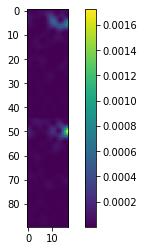

In [17]:
plt.figure()
plt.imshow(x_train[1])
plt.colorbar()
plt.show()

In [18]:
#convertir de 3D a 5D
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(140, 1, 90, 17, 1)
(140, 1, 90, 17, 1)


In [19]:
mc = ModelCheckpoint('/content/drive/My Drive/BCI-II-III/Modelos/STFT_RNN.hdf5',
                     monitor='val_accuracy', save_best_only=True, verbose=0)

In [20]:
def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu', padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu', padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32, activation='tanh', dropout=0.5))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
loss:  0.4359711834362575
accuracy:  0.8071428537368774
confusion matrix:
 [[60 10]
 [17 53]]


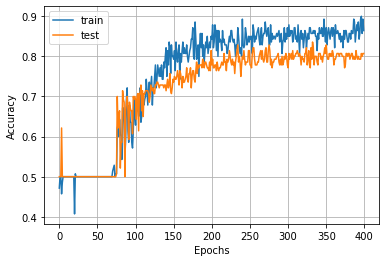

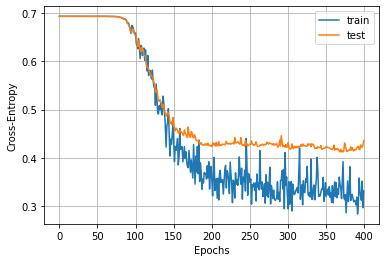

Iteration: 2
loss:  0.4223417213984898
accuracy:  0.800000011920929
confusion matrix:
 [[55 15]
 [13 57]]


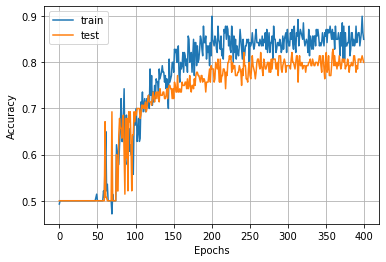

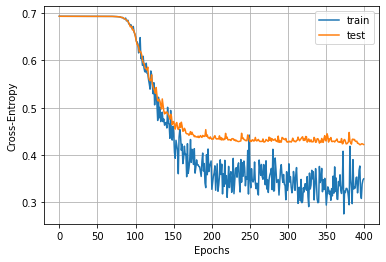

Iteration: 3
loss:  0.4169004414762769
accuracy:  0.7785714268684387
confusion matrix:
 [[56 14]
 [17 53]]


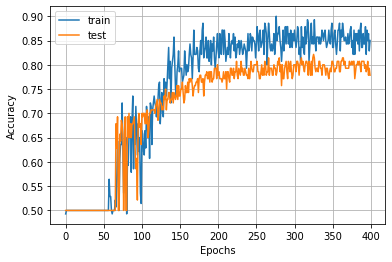

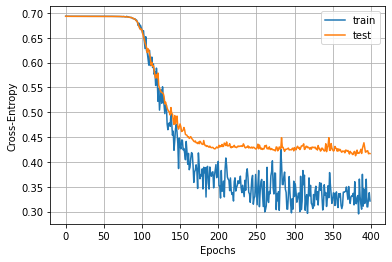

Iteration: 4
loss:  0.4195931426116398
accuracy:  0.7857142686843872
confusion matrix:
 [[54 16]
 [14 56]]


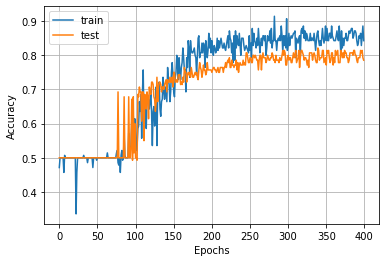

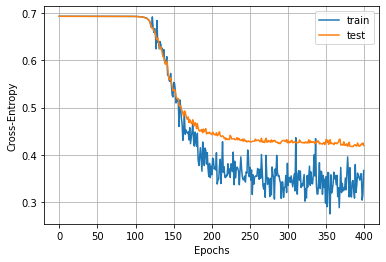

Iteration: 5
loss:  0.4279402562550136
accuracy:  0.7928571701049805
confusion matrix:
 [[53 17]
 [12 58]]


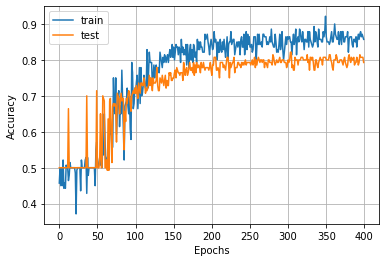

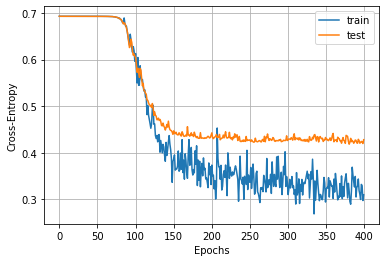


Resultados:
loss: [0.4359711834362575, 0.4223417213984898, 0.4169004414762769, 0.4195931426116398, 0.4279402562550136]
accuracy: [0.8071428537368774, 0.800000011920929, 0.7785714268684387, 0.7857142686843872, 0.7928571701049805]
Tiempo: 178.64233136177063


In [25]:
inicio = time.time()
array_loss = []
array_acc = []
for i in range(5):
  print("Iteration:", i+1)
    
  model = CNN_2D_LSTM_TD()

  history = model.fit(x_train, y_train, epochs=400, batch_size=16,
                      validation_data=(x_test, y_test), verbose=0,
                      callbacks=[mc])
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
fin = time.time()
tiempo = fin - inicio
print("Tiempo:", tiempo)

In [26]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_46 (TimeDis (None, 1, 90, 17, 64)     640       
_________________________________________________________________
time_distributed_47 (TimeDis (None, 1, 45, 8, 64)      0         
_________________________________________________________________
time_distributed_48 (TimeDis (None, 1, 45, 8, 64)      36928     
_________________________________________________________________
time_distributed_49 (TimeDis (None, 1, 22, 4, 64)      0         
_________________________________________________________________
time_distributed_50 (TimeDis (None, 1, 5632)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                725120    
_________________________________________________________________
dense_19 (Dense)             (None, 256)             

In [27]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Tiempo:", int(tiempo))

Mean Accuracy: 0.7929
std: (+/- 0.0101)
Max Accuracy: 0.8071
Tiempo: 178


In [28]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jul 27 05:02:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    32W / 250W |   1189MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------